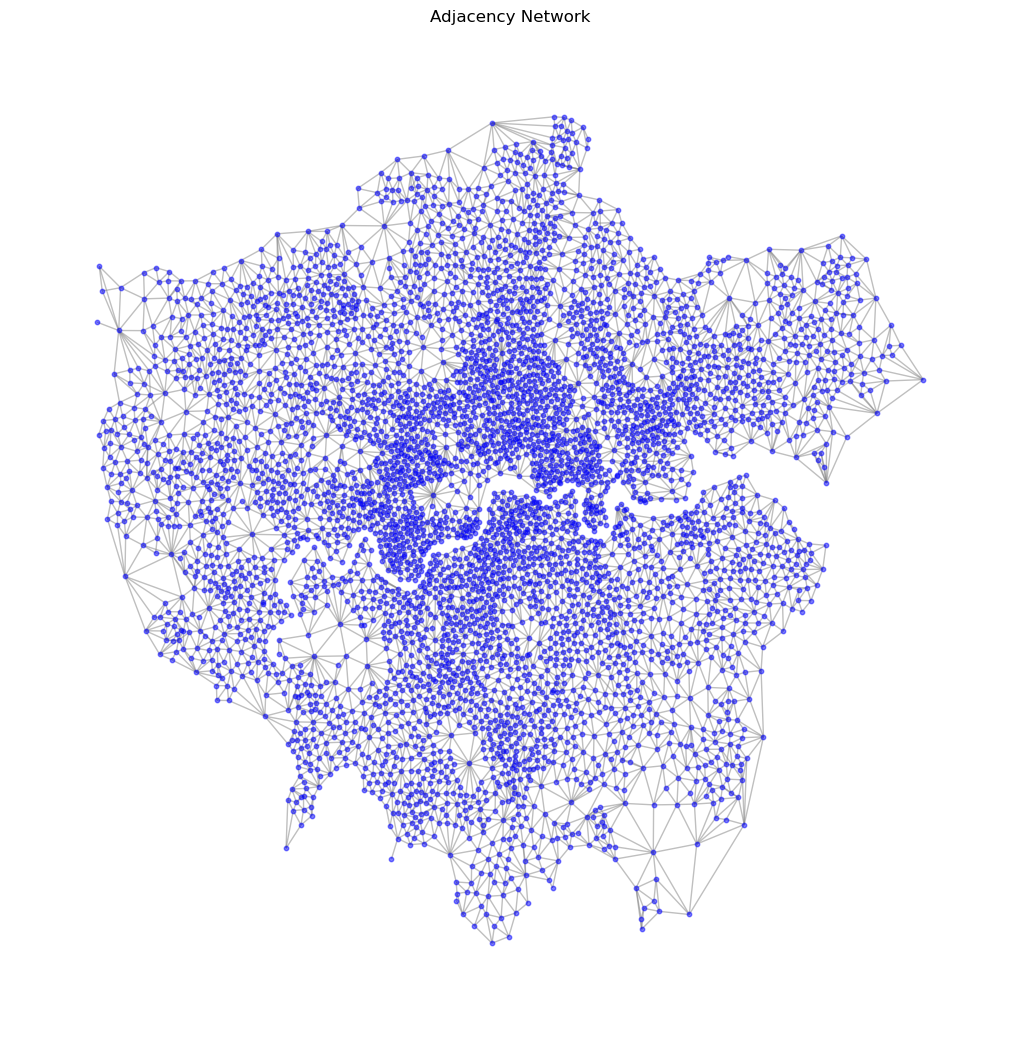

In [1]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn.functional as F
from torch_geometric.nn import GINConv, global_add_pool
from torch_geometric.utils import from_networkx
from statsmodels.stats.outliers_influence import variance_inflation_factor
import random
import itertools
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 读取CSV文件并创建GeoDataFrame
csv_file = 'LondonLSOAs.csv'
df = pd.read_csv(csv_file)

# 创建几何对象（假设geometry列包含WKT格式的多边形数据）
gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df['geometry']))

# 设置坐标系 (假设是WGS84坐标系)
gdf.set_crs(epsg=27700, inplace=True)

# 计算每个LSOA的几何中心点
gdf['geo_centroid'] = gdf.centroid
coords = np.array(list(zip(gdf.geo_centroid.x, gdf.geo_centroid.y)))
coords4geocoding = torch.tensor([gdf.centroid.x, gdf.centroid.y], dtype=torch.float).transpose(0, 1)
# 转换为投影坐标系（例如，英国国家格网EPSG:27700）
# gdf = gdf.to_crs(epsg=27700)
# 计算相邻关系
neighbors = gpd.sjoin(gdf, gdf, how='left', predicate='intersects')

# 手动处理索引
neighbors = neighbors[neighbors.index != neighbors.index_right]

# 构建邻接矩阵
G = nx.Graph()

# 添加节点
for idx, row in gdf.iterrows():
    G.add_node(idx, pos=(row.geo_centroid.x, row.geo_centroid.y))

# 添加边，根据相邻关系
for idx, row in neighbors.iterrows():
    G.add_edge(row.name, row['index_right'], weight=1)

# 可视化邻接关系
pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(10, 10))
nx.draw(G, pos, node_size=10, node_color='blue', edge_color='grey', alpha=0.5)
plt.title("Adjacency Network")
plt.show()

In [2]:
# 读取CSV文件并创建GeoDataFrame
csv_file = 'LondonLSOAs.csv'
df = pd.read_csv(csv_file)

# 创建几何对象（假设geometry列包含WKT格式的多边形数据）
gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df['geometry']))

# 设置坐标系 (假设是WGS84坐标系)
gdf.set_crs(epsg=4326, inplace=True)

# 固定选取的变量
fixed_columns = [
    'c_percent Aged 10 to 14 years', 'c_percent Aged 15 to 19 years',
       'c_percent Aged 20 to 24 years', 'c_percent Aged 25 to 29 years',
       'c_percent Aged 30 to 34 years', 'c_percent Aged 35 to 39 years',
       'c_percent Aged 40 to 44 years', 'c_percent Aged 65 to 69 years',
       'c_percent Aged 70 to 74 years', 'c_percent Aged 75 to 79 years',
       'c_percent Aged 80 to 84 years', 'c_percent Aged 85 years and over',
       'c_percent mixed', 'c_percent white',
       'c_percent 2. Professional occupations', 'c_pop_density', 'e_NO2',
       'e_ndvi', 'e_water', 'e_trees', 'e_grass', 'e_bare', 'c_percent asian',
       'c_percent black', 'c_percent buddhist', 'c_percent muslim',
       'c_percent no central heating', 'c_percent communal heating',
       'c_percent TFW less than 2km', 'c_percent 49 or more hours worked',
       'c_percent commute on foot', 'c_percent commute metro rail',
       'c_percent commute bus', 'c_percent commute bicycle',
       'c_percent student moved to address',
       'c_percent occupancy rating bedrooms -2',
       'c_percent occupancy rating bedrooms -1', 'c_percent 10 years or more',
       'c_percent 2 years or more but less than 5 years',
       'c_percent 5 years or more but less than 10 years',
       # 'c_percent married or in a registered civil partnership married same sex',
       'c_percent married or in a registered civil partnership in a registered civil partnership',
       'c_percent separated but still legally married or still legally in a civil partnership separated but still in a registered civil partnership',
       'c_percent divorced or civil partnership dissolved formerly in a civil partnership now legally dissolved',
       'c_percent   cannot speak english well',
       'c_percent   cannot speak english',
       'c_percent households deprived in four dimensions',
       'c_percent christian', 'c_percent WFH', 'c_percent part-time',
       'c_percent commute train', 'c_percent outside UK moved to address',
       'c_percent occupancy rating bedrooms +2',
       'c_percent 3. Associate professional and technical occupations',
       'c_percent 5. Skilled trades occupations',
       'c_percent 6. Caring leisure and other service occupations',
       'c_percent divorced or civil partnership dissolved',
       'e_lake_mix_layer_depth', 'e_snow_cover', 'e_surface_runoff_sum',
       'e_snow_and_ice', 'e_crops', 'e_evaporation_from_the_top_of_canopy_sum',
       'e_shrub_and_scrub'
]

# 提取固定变量
fixed_features = gdf[fixed_columns].apply(pd.to_numeric, errors='coerce')

# 使用邻接节点的均值填充空值
for i, row in fixed_features.iterrows():
    for col in fixed_columns:
        if pd.isna(row[col]):
            neighbor_indices = list(G.neighbors(i))
            if neighbor_indices:  # 确保有邻居
                neighbor_values = fixed_features.iloc[neighbor_indices][col]
                mean_value = neighbor_values.mean()
                if pd.isna(mean_value):
                    mean_value = fixed_features[col].mean()  # 如果邻居的均值还是nan，使用全局均值填充
                fixed_features.at[i, col] = mean_value
            else:
                fixed_features.at[i, col] = fixed_features[col].mean()  # 如果没有邻居，使用全局均值填充

# 再次检查是否有任何nan值
print("Remaining NaN count:", fixed_features.isna().sum().sum())

# 计算VIF
def calculate_vif(df):
    vif = pd.DataFrame()
    vif["Variable"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

vif_df = calculate_vif(fixed_features)
# 设置显示选项，防止输出省略
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print(vif_df)

# 进行标准化
scaler = StandardScaler()
final_features_scaled = scaler.fit_transform(fixed_features)
final_features_tensor = torch.tensor(final_features_scaled, dtype=torch.float)

# 准备目标变量
target_column = 'o_depression_quantity_per_capita'
target = gdf[target_column].apply(pd.to_numeric, errors='coerce').fillna(0)
targets = torch.tensor(target.values, dtype=torch.float).unsqueeze(1)  # 添加维度以匹配模型输出

# 将 NetworkX 图转换为 PyTorch Geometric 数据
from torch_geometric.utils import from_networkx
data = from_networkx(G)
data.x = final_features_tensor
data.y = targets

Remaining NaN count: 0
                                             Variable          VIF
0                       c_percent Aged 10 to 14 years    55.868596
1                       c_percent Aged 15 to 19 years    22.219294
2                       c_percent Aged 20 to 24 years    39.900070
3                       c_percent Aged 25 to 29 years    42.327632
4                       c_percent Aged 30 to 34 years    65.695808
5                       c_percent Aged 35 to 39 years    76.727955
6                       c_percent Aged 40 to 44 years    77.304368
7                       c_percent Aged 65 to 69 years    37.196747
8                       c_percent Aged 70 to 74 years    35.156901
9                       c_percent Aged 75 to 79 years    27.160777
10                      c_percent Aged 80 to 84 years    20.075569
11                   c_percent Aged 85 years and over    10.407913
12                                    c_percent mixed    30.521846
13                                    c

# 随机游走

In [10]:
# 定义 random_walk 函数
def random_walk(G, start_node, length):
    path = [start_node]
    for _ in range(length - 1):
        neighbors = list(G.neighbors(path[-1]))
        if neighbors:
            next_node = random.choice(neighbors)
            path.append(next_node)
        else:
            break
    return path

def get_path_features(G, path):
    # 计算路径上的平均度数
    degrees = np.mean([G.degree(node) for node in path])
    return np.array([degrees])

# 为每个节点生成随机游走并计算特征
additional_features = []
for node in G.nodes():
    path = random_walk(G, node, 10)  # 随机游走长度为10
    path_features = get_path_features(G, path)
    additional_features.append(path_features)

# 更新 PyTorch Geometric 数据
additional_features = torch.tensor(additional_features, dtype=torch.float)
data.x = torch.cat((data.x, additional_features), dim=1)

C:\Users\0\AppData\Local\Temp\ipykernel_27028\4123325436.py:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:277.)
  additional_features = torch.tensor(additional_features, dtype=torch.float)


In [11]:
data

Data(edge_index=[2, 29472], pos=[4994, 2], weight=[29472], x=[4994, 64], y=[4994, 1])

# SATCLIP

In [4]:
import sys
sys.path.append('./satclip/satclip')

import torch
from load import get_satclip

satclip_path = 'satclip-resnet18-l10.ckpt'

# 定义计算设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载模型
model = get_satclip(satclip_path, device=device)

# 假设coords4geocoding是你的LSOA坐标
# 使用模型进行推断
with torch.no_grad():
    x = model(coords4geocoding.double().to(device)).detach().cpu()

# 打印输出特征的形状
print(x.shape)


INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.12 (you have 1.4.11). Upgrade using: pip install --upgrade albumentations


using pretrained moco resnet18
torch.Size([4994, 256])


In [8]:
data

Data(edge_index=[2, 97544], pos=[4994, 2], weight=[97544], x=[4994, 63], y=[4994, 1])

In [5]:
# 将输出转换为 float 类型（如果输出是 double 类型的话）
x = x.float()

# 接下来，你可以将这个处理过的 x 放入你的 GNN 中
# 例如，将这个特征拼接到你的图数据特征上
data.x = torch.cat([data.x, x], dim=1)

In [10]:
data

Data(edge_index=[2, 97544], pos=[4994, 2], weight=[97544], x=[4994, 319], y=[4994, 1])

# 模型

In [7]:
import torch
from torch_geometric.utils import k_hop_subgraph
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
import itertools
import random

# 定义GATv2模型
class GATv2(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GATv2, self).__init__()
        self.conv1 = GATv2Conv(in_channels, hidden1, heads=1)
        self.bn1 = torch.nn.BatchNorm1d(hidden1)  # Batch normalization
        self.conv2 = GATv2Conv(hidden1, hidden2, heads=1)
        self.bn2 = torch.nn.BatchNorm1d(hidden2)  # Batch normalization
        self.fc1 = torch.nn.Linear(hidden2, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)  # Batch normalization
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        x = self.conv2(x, edge_index)
        x = self.bn2(x)  # Batch normalization
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        x = self.fc1(x)
        return x

def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.mse_loss(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        loss = F.mse_loss(out, data.y).item()
    return loss

# 定义早停机制
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def step(self, loss):
        if loss < self.best_loss - self.min_delta:
            self.best_loss = loss
            self.counter = 0
        else:
            self.counter += 1

        return self.counter >= self.patience

# 定义划分子图的函数
def create_subgraph(data, train_idx, test_idx, num_hops):
    train_idx = torch.tensor(train_idx, dtype=torch.long, device=data.edge_index.device)
    test_idx = torch.tensor(test_idx, dtype=torch.long, device=data.edge_index.device)
    
    # 获取训练集子图，包含 train_idx 节点以及 num_hops 范围内的邻居
    train_subgraph = k_hop_subgraph(train_idx, num_hops, data.edge_index, relabel_nodes=True)
    train_edge_index, train_x, train_y = train_subgraph[1], data.x[train_subgraph[0]], data.y[train_subgraph[0]]
    
    # 获取测试集子图，包含 test_idx 节点以及 num_hops 范围内的邻居
    test_subgraph = k_hop_subgraph(test_idx, num_hops, data.edge_index, relabel_nodes=True)
    test_edge_index, test_x, test_y = test_subgraph[1], data.x[test_subgraph[0]], data.y[test_subgraph[0]]
    
    return (train_x, train_edge_index, train_y), (test_x, test_edge_index, test_y)

# 超参数搜索函数
def hyperparameter_search(data, param_space, k=5, num_hops=2, num_samples=20):
    best_loss = float('inf')
    best_params = None
    random_params = [dict(zip(param_space, v)) for v in random.sample(list(itertools.product(*param_space.values())), num_samples)]
    
    for param_idx, params in enumerate(random_params):
        print(f'Starting hyperparameter set {param_idx + 1}/{num_samples}: {params}')
        kf = KFold(n_splits=k, shuffle=True, random_state=42)
        fold_losses = []
        
        for fold, (train_idx, test_idx) in enumerate(kf.split(np.arange(data.num_nodes))):
            print(f'Starting fold {fold + 1}/{k} for hyperparameter set {param_idx + 1}/{num_samples}')
            (train_x, train_edge_index, train_y), (test_x, test_edge_index, test_y) = create_subgraph(data, train_idx, test_idx, num_hops)
            
            # 重新初始化模型和优化器
            model = GATv2(
                in_channels=train_x.shape[1], 
                hidden1=params['hidden1'], 
                hidden2=params['hidden2'], 
                out_channels=train_y.shape[1], 
                dropout=params['dropout']
            )
            optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
            early_stopping = EarlyStopping(patience=10)
            
            # 训练模型
            for epoch in range(params['num_epochs']):
                loss = train(model, optimizer, data)
                val_loss = evaluate(model, data)
                scheduler.step(val_loss)
                
                if (epoch + 1) % 10 == 0:
                    print(f'Hyperparameter set {param_idx + 1}/{num_samples}, Fold {fold + 1}/{k}, Epoch {epoch + 1}/{params["num_epochs"]}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}')
                
                if early_stopping.step(val_loss):
                    print(f'Early stopping at epoch {epoch + 1}')
                    break
            
            # 测试模型
            model.eval()
            with torch.no_grad():
                pred = model(test_x, test_edge_index)
                fold_loss = F.mse_loss(pred, test_y).item()
                fold_losses.append(fold_loss)
        
        avg_fold_loss = np.mean(fold_losses)
        print(f'Average loss for hyperparameter set {param_idx + 1}/{num_samples}: {avg_fold_loss:.4f}')
        if avg_fold_loss < best_loss:
            best_loss = avg_fold_loss
            best_params = params
    
    return best_params, best_loss

# 定义K-Fold交叉验证
def k_fold_cross_validation(data, best_params, k=5, num_hops=2):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    results = []

    all_indices = np.arange(data.num_nodes)
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(all_indices)):
        print(f'Starting fold {fold + 1}/{k}')
        (train_x, train_edge_index, train_y), (test_x, test_edge_index, test_y) = create_subgraph(data, train_idx, test_idx, num_hops)
        
        # 重新初始化模型和优化器
        model = GATv2(
            in_channels=train_x.shape[1], 
            hidden1=best_params['hidden1'], 
            hidden2=best_params['hidden2'], 
            out_channels=train_y.shape[1], 
            dropout=best_params['dropout']
        )
        optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
        early_stopping = EarlyStopping(patience=10)
        
        # 训练模型
        model.train()
        for epoch in range(best_params['num_epochs']):
            loss = train(model, optimizer, data)
            val_loss = evaluate(model, data)
            scheduler.step(val_loss)
            
            if (epoch + 1) % 10 == 0:
                print(f'Fold {fold + 1}/{k}, Epoch {epoch + 1}/{best_params["num_epochs"]}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}')
            
            if early_stopping.step(val_loss):
                print(f'Early stopping at epoch {epoch + 1}')
                break
        
        # 测试模型
        model.eval()
        with torch.no_grad():
            pred = model(test_x, test_edge_index)
            y_true = test_y.numpy()
            y_pred = pred.numpy()
            
            mse = mean_squared_error(y_true, y_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_true, y_pred)
            r2 = r2_score(y_true, y_pred)
        
        print(f'Fold {fold + 1} results - MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}')
        results.append((mse, rmse, mae, r2))
    
    return results

# 假设你已经有一个数据对象 data
# data = ...

# 定义超参数空间
param_space = {
    'lr': [0.001, 0.005, 0.01],
    'weight_decay': [5e-4, 1e-3, 5e-3],
    'hidden1': [128,256,512],
    'hidden2': [128, 64, 32],
    'dropout': [0.3, 0.5, 0.7],
    'num_epochs': [100]
}

# 使用K-Fold交叉验证进行超参数搜索
best_params, best_loss = hyperparameter_search(data, param_space)
print(f'Best params: {best_params}, Best loss: {best_loss:.4f}')

# 使用最佳超参数进行K-Fold交叉验证
results = k_fold_cross_validation(data, best_params)

# 打印K-Fold结果
for fold, (mse, rmse, mae, r2) in enumerate(results):
    print(f'Fold {fold + 1} - MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}')

# 计算平均结果
avg_results = np.mean(results, axis=0)
print(f'Average - MSE: {avg_results[0]:.4f}, RMSE: {avg_results[1]:.4f}, MAE: {avg_results[2]:.4f}, R²: {avg_results[3]:.4f}')


Starting hyperparameter set 1/20: {'lr': 0.005, 'weight_decay': 0.005, 'hidden1': 128, 'hidden2': 64, 'dropout': 0.3, 'num_epochs': 100}
Starting fold 1/5 for hyperparameter set 1/20
Hyperparameter set 1/20, Fold 1/5, Epoch 10/100, Loss: 246.1071, Val Loss: 197.1984
Hyperparameter set 1/20, Fold 1/5, Epoch 20/100, Loss: 191.2903, Val Loss: 112.9957
Hyperparameter set 1/20, Fold 1/5, Epoch 30/100, Loss: 138.5151, Val Loss: 94.4994
Hyperparameter set 1/20, Fold 1/5, Epoch 40/100, Loss: 93.0022, Val Loss: 61.6672
Hyperparameter set 1/20, Fold 1/5, Epoch 50/100, Loss: 57.2241, Val Loss: 44.2193
Hyperparameter set 1/20, Fold 1/5, Epoch 60/100, Loss: 36.7633, Val Loss: 30.9574
Hyperparameter set 1/20, Fold 1/5, Epoch 70/100, Loss: 29.1831, Val Loss: 26.6561
Hyperparameter set 1/20, Fold 1/5, Epoch 80/100, Loss: 24.2144, Val Loss: 20.8058
Hyperparameter set 1/20, Fold 1/5, Epoch 90/100, Loss: 20.7863, Val Loss: 19.0923
Hyperparameter set 1/20, Fold 1/5, Epoch 100/100, Loss: 19.5840, Val Loss:

KeyboardInterrupt: 

In [12]:
best_params = {'lr': 0.005,
 'weight_decay': 0.005,
 'hidden1': 128,
 'hidden2': 64,
 'dropout': 0.3,
 'num_epochs': 200}

In [9]:
# 使用最佳超参数进行K-Fold交叉验证
results = k_fold_cross_validation(data, best_params)

# 打印K-Fold结果
for fold, (mse, rmse, mae, r2) in enumerate(results):
    print(f'Fold {fold + 1} - MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}')

# 计算平均结果
avg_results = np.mean(results, axis=0)
print(f'Average - MSE: {avg_results[0]:.4f}, RMSE: {avg_results[1]:.4f}, MAE: {avg_results[2]:.4f}, R²: {avg_results[3]:.4f}')

Starting fold 1/5
Fold 1/5, Epoch 10/200, Loss: 247.1487, Val Loss: 211.9166
Fold 1/5, Epoch 20/200, Loss: 188.1357, Val Loss: 133.3694
Fold 1/5, Epoch 30/200, Loss: 133.1932, Val Loss: 89.4396
Fold 1/5, Epoch 40/200, Loss: 87.9035, Val Loss: 63.8477
Fold 1/5, Epoch 50/200, Loss: 53.6800, Val Loss: 42.2423
Fold 1/5, Epoch 60/200, Loss: 33.2975, Val Loss: 30.2801
Fold 1/5, Epoch 70/200, Loss: 25.8377, Val Loss: 22.6895
Fold 1/5, Epoch 80/200, Loss: 21.1883, Val Loss: 16.8874
Fold 1/5, Epoch 90/200, Loss: 18.6098, Val Loss: 13.8429
Fold 1/5, Epoch 100/200, Loss: 16.6622, Val Loss: 12.9283
Fold 1/5, Epoch 110/200, Loss: 16.0602, Val Loss: 11.9383
Fold 1/5, Epoch 120/200, Loss: 17.2238, Val Loss: 11.8550
Fold 1/5, Epoch 130/200, Loss: 14.2256, Val Loss: 9.7166
Fold 1/5, Epoch 140/200, Loss: 14.2672, Val Loss: 9.1871
Fold 1/5, Epoch 150/200, Loss: 14.9254, Val Loss: 9.0039
Fold 1/5, Epoch 160/200, Loss: 14.0164, Val Loss: 8.8316
Fold 1/5, Epoch 170/200, Loss: 13.9210, Val Loss: 8.7409
Fold 

C:\Users\0\anaconda3\envs\envGEOG0051\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Fold 2/5, Epoch 10/200, Loss: 237.7886, Val Loss: 185.0428
Fold 2/5, Epoch 20/200, Loss: 176.3076, Val Loss: 94.4062
Fold 2/5, Epoch 30/200, Loss: 122.0900, Val Loss: 75.3132
Fold 2/5, Epoch 40/200, Loss: 80.2085, Val Loss: 58.5070
Fold 2/5, Epoch 50/200, Loss: 52.4941, Val Loss: 42.7944
Fold 2/5, Epoch 60/200, Loss: 35.7466, Val Loss: 31.7435
Fold 2/5, Epoch 70/200, Loss: 26.5757, Val Loss: 23.9621
Fold 2/5, Epoch 80/200, Loss: 22.6148, Val Loss: 20.2279
Fold 2/5, Epoch 90/200, Loss: 21.1639, Val Loss: 16.6199
Fold 2/5, Epoch 100/200, Loss: 20.5284, Val Loss: 15.2880
Fold 2/5, Epoch 110/200, Loss: 20.1445, Val Loss: 14.7561
Fold 2/5, Epoch 120/200, Loss: 19.3702, Val Loss: 13.9176
Fold 2/5, Epoch 130/200, Loss: 18.5419, Val Loss: 13.4294
Fold 2/5, Epoch 140/200, Loss: 18.0316, Val Loss: 12.9409
Fold 2/5, Epoch 150/200, Loss: 17.8359, Val Loss: 12.6048
Fold 2/5, Epoch 160/200, Loss: 17.6786, Val Loss: 12.2359
Fold 2/5, Epoch 170/200, Loss: 17.2737, Val Loss: 12.0007
Fold 2/5, Epoch 180

C:\Users\0\anaconda3\envs\envGEOG0051\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Fold 3/5, Epoch 10/200, Loss: 245.9889, Val Loss: 199.9629
Fold 3/5, Epoch 20/200, Loss: 189.3841, Val Loss: 118.4888
Fold 3/5, Epoch 30/200, Loss: 136.5363, Val Loss: 77.3343
Fold 3/5, Epoch 40/200, Loss: 90.6872, Val Loss: 56.0537
Fold 3/5, Epoch 50/200, Loss: 56.5982, Val Loss: 36.5116
Fold 3/5, Epoch 60/200, Loss: 35.0898, Val Loss: 24.8463
Fold 3/5, Epoch 70/200, Loss: 27.5093, Val Loss: 20.3369
Fold 3/5, Epoch 80/200, Loss: 21.0938, Val Loss: 17.2755
Fold 3/5, Epoch 90/200, Loss: 17.8547, Val Loss: 12.6823
Fold 3/5, Epoch 100/200, Loss: 15.9807, Val Loss: 11.7770
Fold 3/5, Epoch 110/200, Loss: 14.6439, Val Loss: 10.3774
Fold 3/5, Epoch 120/200, Loss: 14.0713, Val Loss: 8.7583
Fold 3/5, Epoch 130/200, Loss: 14.2605, Val Loss: 8.4249
Fold 3/5, Epoch 140/200, Loss: 14.0794, Val Loss: 8.1794
Fold 3/5, Epoch 150/200, Loss: 13.3935, Val Loss: 7.8294
Fold 3/5, Epoch 160/200, Loss: 13.3822, Val Loss: 7.6755
Fold 3/5, Epoch 170/200, Loss: 13.3184, Val Loss: 7.5320
Fold 3/5, Epoch 180/200,

C:\Users\0\anaconda3\envs\envGEOG0051\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Fold 4/5, Epoch 10/200, Loss: 264.5635, Val Loss: 239.0876
Fold 4/5, Epoch 20/200, Loss: 211.5428, Val Loss: 201.0126
Fold 4/5, Epoch 30/200, Loss: 156.1506, Val Loss: 100.6074
Fold 4/5, Epoch 40/200, Loss: 104.9158, Val Loss: 67.2254
Fold 4/5, Epoch 50/200, Loss: 64.2533, Val Loss: 48.5697
Fold 4/5, Epoch 60/200, Loss: 40.3917, Val Loss: 34.4561
Fold 4/5, Epoch 70/200, Loss: 28.0535, Val Loss: 32.0185
Fold 4/5, Epoch 80/200, Loss: 23.3967, Val Loss: 21.2225
Fold 4/5, Epoch 90/200, Loss: 20.5235, Val Loss: 17.5140
Fold 4/5, Epoch 100/200, Loss: 17.8001, Val Loss: 13.8004
Fold 4/5, Epoch 110/200, Loss: 20.7160, Val Loss: 13.1108
Fold 4/5, Epoch 120/200, Loss: 17.7241, Val Loss: 12.1586
Fold 4/5, Epoch 130/200, Loss: 15.7659, Val Loss: 10.7018
Fold 4/5, Epoch 140/200, Loss: 15.3726, Val Loss: 10.0881
Fold 4/5, Epoch 150/200, Loss: 15.0608, Val Loss: 9.6317
Fold 4/5, Epoch 160/200, Loss: 14.4677, Val Loss: 9.3874
Fold 4/5, Epoch 170/200, Loss: 14.2223, Val Loss: 9.1996
Fold 4/5, Epoch 180

C:\Users\0\anaconda3\envs\envGEOG0051\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Fold 5/5, Epoch 10/200, Loss: 243.8991, Val Loss: 188.1304
Fold 5/5, Epoch 20/200, Loss: 182.9671, Val Loss: 113.1485
Fold 5/5, Epoch 30/200, Loss: 128.1384, Val Loss: 82.3915
Fold 5/5, Epoch 40/200, Loss: 83.5310, Val Loss: 58.0140
Fold 5/5, Epoch 50/200, Loss: 52.6712, Val Loss: 39.8664
Fold 5/5, Epoch 60/200, Loss: 34.5031, Val Loss: 30.6372
Fold 5/5, Epoch 70/200, Loss: 26.0235, Val Loss: 24.7744
Fold 5/5, Epoch 80/200, Loss: 21.7179, Val Loss: 17.2050
Fold 5/5, Epoch 90/200, Loss: 19.2541, Val Loss: 16.8630
Fold 5/5, Epoch 100/200, Loss: 16.9477, Val Loss: 13.0482
Fold 5/5, Epoch 110/200, Loss: 15.4404, Val Loss: 11.9442
Fold 5/5, Epoch 120/200, Loss: 14.3217, Val Loss: 10.9062
Fold 5/5, Epoch 130/200, Loss: 13.7974, Val Loss: 9.6211
Fold 5/5, Epoch 140/200, Loss: 13.0951, Val Loss: 8.2287
Fold 5/5, Epoch 150/200, Loss: 11.6765, Val Loss: 7.0254
Fold 5/5, Epoch 160/200, Loss: 11.4145, Val Loss: 6.3297
Fold 5/5, Epoch 170/200, Loss: 11.5290, Val Loss: 6.1182
Fold 5/5, Epoch 180/200

Epoch 10/200, Loss: 241.5097
Epoch 20/200, Loss: 186.0134
Epoch 30/200, Loss: 133.4569
Epoch 40/200, Loss: 88.6486
Epoch 50/200, Loss: 56.5153
Epoch 60/200, Loss: 38.1380
Epoch 70/200, Loss: 29.5349
Epoch 80/200, Loss: 25.5318
Epoch 90/200, Loss: 22.6067
Epoch 100/200, Loss: 20.8859
Epoch 110/200, Loss: 19.5032
Epoch 120/200, Loss: 18.0154
Epoch 130/200, Loss: 17.1762
Epoch 140/200, Loss: 16.4739
Epoch 150/200, Loss: 15.4762
Epoch 160/200, Loss: 14.3352
Epoch 170/200, Loss: 14.1046
Epoch 180/200, Loss: 13.8432
Epoch 190/200, Loss: 13.7595
Epoch 200/200, Loss: 12.7234
Shape of conv1 embeddings: (4994, 128)
Shape of conv2 embeddings: (4994, 64)
Explained Variance Ratio: [0.7466307]
PCA1 Top Contributors:
40    0.017786
2     0.016903
18    0.016333
10    0.015751
27    0.015167
22    0.015151
25    0.014847
17    0.014831
54    0.014809
13    0.014775
53    0.014695
16    0.014545
34    0.014419
42    0.014411
30    0.014329
56    0.014313
24    0.014080
33    0.013876
55    0.013864
29 

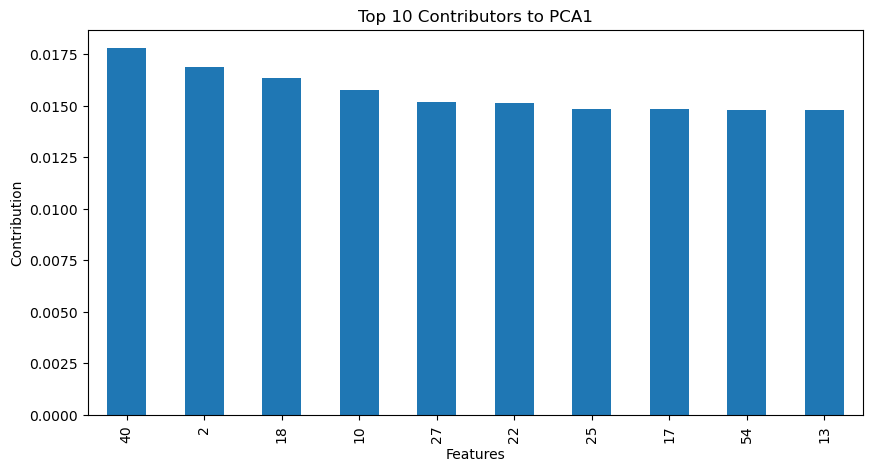

In [13]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# 定义GATv2模型
class GATv2(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GATv2, self).__init__()
        self.conv1 = GATv2Conv(in_channels, hidden1, heads=1)
        self.bn1 = torch.nn.BatchNorm1d(hidden1)  # Batch normalization
        self.conv2 = GATv2Conv(hidden1, hidden2, heads=1)
        self.bn2 = torch.nn.BatchNorm1d(hidden2)  # Batch normalization
        self.fc1 = torch.nn.Linear(hidden2, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)  # Batch normalization
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        conv1_out = x  # 保存第一层卷积的输出
        x = self.conv2(x, edge_index)
        x = self.bn2(x)  # Batch normalization
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        conv2_out = x  # 保存第二层卷积的输出
        x = self.fc1(x)
        return conv1_out, conv2_out, x

def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    _, _, out = model(data.x, data.edge_index)
    loss = F.mse_loss(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

def train_with_best_params(data, best_params, num_epochs=200):
    model = GATv2(
        in_channels=data.x.shape[1], 
        hidden1=best_params['hidden1'], 
        hidden2=best_params['hidden2'], 
        out_channels=data.y.shape[1], 
        dropout=best_params['dropout']
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
    
    losses = []
    for epoch in range(num_epochs):
        loss = train(model, optimizer, data)
        losses.append(loss)
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss:.4f}')
    return model, losses

# 使用最佳参数训练模型
# 假设你已经有一个数据对象 data 和最佳参数 best_params
# best_params = {'lr': 0.005, 'weight_decay': 0.001, 'hidden1': 64, 'hidden2': 32, 'dropout': 0.5}
model, losses = train_with_best_params(data, best_params)

# 提取嵌入
model.eval()
with torch.no_grad():
    conv1_out, conv2_out, _ = model(data.x, data.edge_index)
    conv1_embeddings = conv1_out.cpu().numpy()
    conv2_embeddings = conv2_out.cpu().numpy()

# 确保嵌入已定义
print(f"Shape of conv1 embeddings: {conv1_embeddings.shape}")
print(f"Shape of conv2 embeddings: {conv2_embeddings.shape}")

# 确保 n_components 设置正确
pca_components = 1
if min(conv2_embeddings.shape) < pca_components:
    pca_components = min(conv2_embeddings.shape)

# 计算PCA并获取解释方差比
pca = PCA(n_components=pca_components, random_state=0)
pca_result = pca.fit_transform(conv2_embeddings)
explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained Variance Ratio: {explained_variance_ratio}")

# 计算载荷
loadings = pca.components_.T

# 计算特征贡献度（解释方差比乘以载荷的平方）
contributions = loadings ** 2 * explained_variance_ratio

# 创建贡献度矩阵DataFrame
contribution_matrix = pd.DataFrame(contributions, columns=[f'PCA{i+1}' for i in range(pca_components)])

# 打印每个主成分的前几个变量及其贡献
print("PCA1 Top Contributors:")
print(contribution_matrix['PCA1'].sort_values(ascending=False).head(20))

if pca_components > 1:
    print("\nPCA2 Top Contributors:")
    print(contribution_matrix['PCA2'].sort_values(ascending=False).head(20))

# 可视化每个主成分的前几个变量及其贡献
plt.figure(figsize=(10, 5))
contribution_matrix['PCA1'].sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Top 10 Contributors to PCA1')
plt.xlabel('Features')
plt.ylabel('Contribution')
plt.show()

if pca_components > 1:
    plt.figure(figsize=(10, 5))
    contribution_matrix['PCA2'].sort_values(ascending=False).head(10).plot(kind='bar')
    plt.title('Top 20 Contributors to PCA2')
    plt.xlabel('Features')
    plt.ylabel('Contribution')
    plt.show()

In [14]:
def plot_variable_v2(gdf, variable, variable_name):

    if variable.startswith('e'):
        colormap = colors.LinearSegmentedColormap.from_list('', ['#ffffff', '#c27ba0'])
    elif variable.startswith('o'):
        colormap = colors.LinearSegmentedColormap.from_list('', ['#ffffff', '#6d9eeb'])
    elif variable.startswith('c'):
        colormap = colors.LinearSegmentedColormap.from_list('', ['#ffffff', '#008080'])
    else:
        colormap = 'coolwarm'

    # Parameters to display missing data in black
    missing_data_color = {
        'color': 'black',
        # 'color':'#808080',
        # 'edgecolor': 'black',
        # 'hatch': '///',  # this is optional, if you'd like a hatch pattern for missing data
        'label': 'Missing Data'
    }

    # Plotting the GeoPandas DataFrame
    ax = gdf.plot(column=variable, legend=True, figsize=(15, 10), cmap=colormap, missing_kwds=missing_data_color)

    # Remove the axes
    plt.axis('off')

    # Customize the legend font size
    # Get the color bar object
    cax = plt.gcf().axes[-1]

    # Customize the color bar font size
    cax.tick_params(labelsize=33)

    # Title
    plt.title(variable_name, fontsize=44)

    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\0\\anaconda3\\envs\\envGEOG0051\\Lib\\site-packages\\matplotlib\\pyplot.py'>

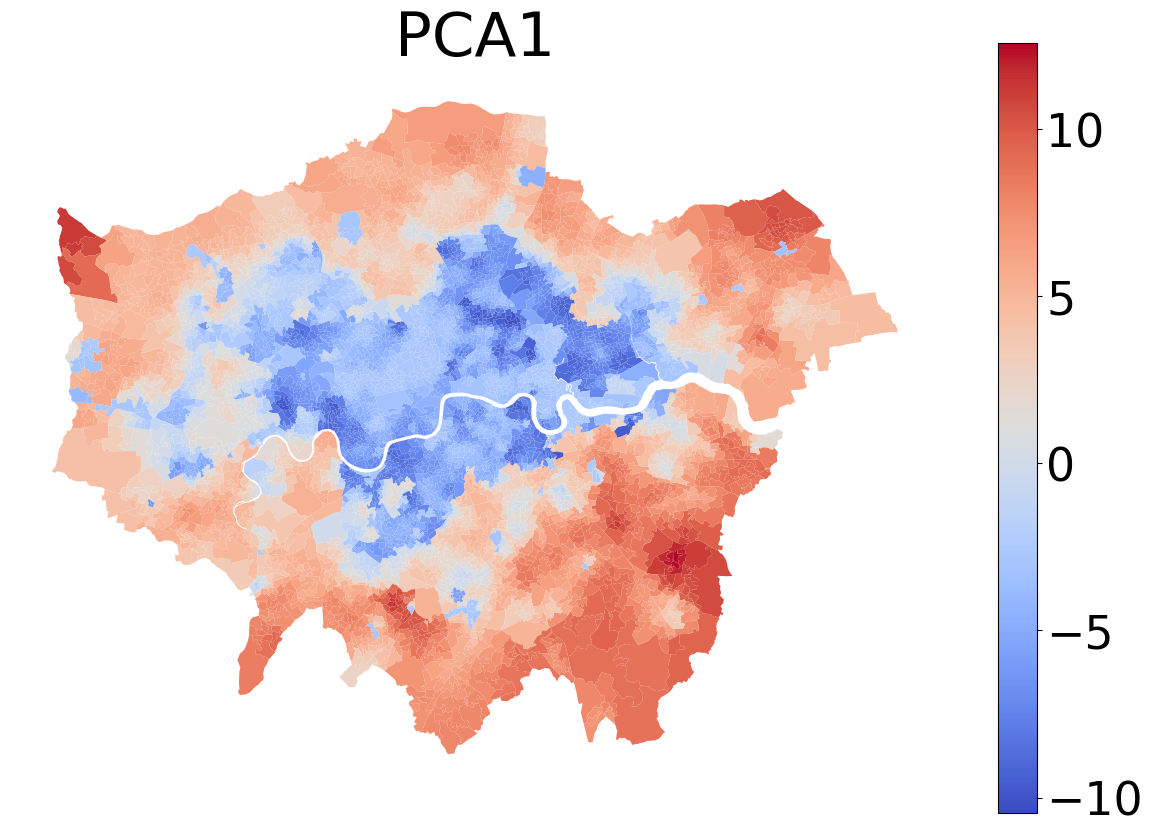

In [15]:
import pandas as pd
import geopandas as gpd
from shapely import wkt

# Read the CSV file
csv_file = 'LondonLSOAs.csv'
df = pd.read_csv(csv_file)

# Convert the 'geometry' column to Shapely geometry objects
df['geometry'] = df['geometry'].apply(wkt.loads)

# Create the GeoDataFrame
gdf_plot = gpd.GeoDataFrame(df, geometry='geometry')

# 将PCA结果添加到GeoDataFrame中
gdf_plot['PCA1'] = pca_result[:, 0]
# gdf_plot['PCA2'] = pca_result[:, 1]
# gdf_plot['PCA3'] = pca_result[:, 2]

# 可视化PCA1和PCA2
plot_variable_v2(gdf_plot, 'PCA1', 'PCA1')
# plot_variable_v2(gdf_plot, 'PCA2', 'PCA2')
# plot_variable_v2(gdf_plot, 'PCA3', 'PCA3')

Correlation with PCA components:
                                                        PCA1
c_percent Aged 10 to 14 years                       0.318840
c_percent Aged 15 to 19 years                       0.096192
c_percent Aged 20 to 24 years                      -0.408412
c_percent Aged 25 to 29 years                      -0.585413
c_percent Aged 30 to 34 years                      -0.530438
c_percent Aged 35 to 39 years                      -0.320627
c_percent Aged 40 to 44 years                       0.032396
c_percent Aged 65 to 69 years                       0.447156
c_percent Aged 70 to 74 years                       0.513681
c_percent Aged 75 to 79 years                       0.495575
c_percent Aged 80 to 84 years                       0.463368
c_percent Aged 85 years and over                    0.447342
c_percent mixed                                    -0.222154
c_percent white                                     0.348145
c_percent 2. Professional occupations              -

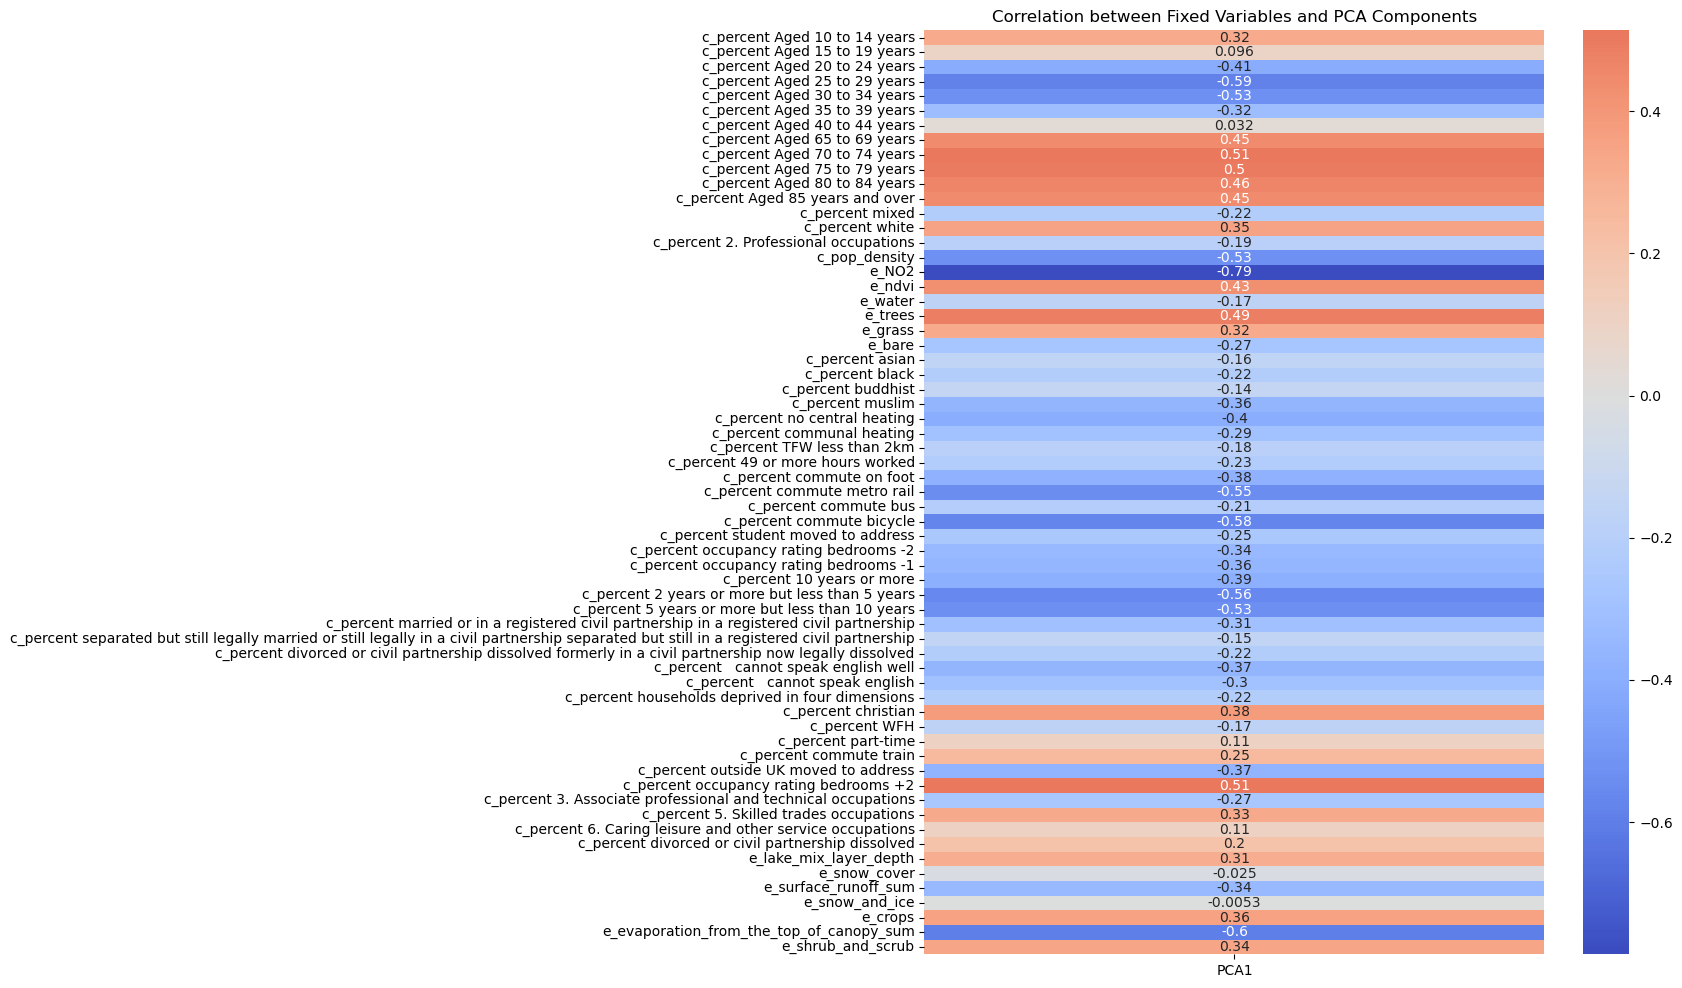

In [16]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
# 提取PCA主成分
pca_df = pd.DataFrame(pca_result, columns=[f'PCA{i+1}' for i in range(pca_components)])

# 读取CSV文件并创建GeoDataFrame
csv_file = 'LondonLSOAs.csv'
df = pd.read_csv(csv_file)

# 创建几何对象（假设geometry列包含WKT格式的多边形数据）
gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df['geometry']))

# 设置坐标系 (假设是WGS84坐标系)
gdf.set_crs(epsg=4326, inplace=True)
# 固定选取的变量
fixed_columns = [
    'c_percent Aged 10 to 14 years', 'c_percent Aged 15 to 19 years',
       'c_percent Aged 20 to 24 years', 'c_percent Aged 25 to 29 years',
       'c_percent Aged 30 to 34 years', 'c_percent Aged 35 to 39 years',
       'c_percent Aged 40 to 44 years', 'c_percent Aged 65 to 69 years',
       'c_percent Aged 70 to 74 years', 'c_percent Aged 75 to 79 years',
       'c_percent Aged 80 to 84 years', 'c_percent Aged 85 years and over',
       'c_percent mixed', 'c_percent white',
       'c_percent 2. Professional occupations', 'c_pop_density', 'e_NO2',
       'e_ndvi', 'e_water', 'e_trees', 'e_grass', 'e_bare', 'c_percent asian',
       'c_percent black', 'c_percent buddhist', 'c_percent muslim',
       'c_percent no central heating', 'c_percent communal heating',
       'c_percent TFW less than 2km', 'c_percent 49 or more hours worked',
       'c_percent commute on foot', 'c_percent commute metro rail',
       'c_percent commute bus', 'c_percent commute bicycle',
       'c_percent student moved to address',
       'c_percent occupancy rating bedrooms -2',
       'c_percent occupancy rating bedrooms -1', 'c_percent 10 years or more',
       'c_percent 2 years or more but less than 5 years',
       'c_percent 5 years or more but less than 10 years',
       # 'c_percent married or in a registered civil partnership married same sex',
       'c_percent married or in a registered civil partnership in a registered civil partnership',
       'c_percent separated but still legally married or still legally in a civil partnership separated but still in a registered civil partnership',
       'c_percent divorced or civil partnership dissolved formerly in a civil partnership now legally dissolved',
       'c_percent   cannot speak english well',
       'c_percent   cannot speak english',
       'c_percent households deprived in four dimensions',
       'c_percent christian', 'c_percent WFH', 'c_percent part-time',
       'c_percent commute train', 'c_percent outside UK moved to address',
       'c_percent occupancy rating bedrooms +2',
       'c_percent 3. Associate professional and technical occupations',
       'c_percent 5. Skilled trades occupations',
       'c_percent 6. Caring leisure and other service occupations',
       'c_percent divorced or civil partnership dissolved',
       'e_lake_mix_layer_depth', 'e_snow_cover', 'e_surface_runoff_sum',
       'e_snow_and_ice', 'e_crops', 'e_evaporation_from_the_top_of_canopy_sum',
       'e_shrub_and_scrub'
]
# 提取固定变量
fixed_features = gdf[fixed_columns].apply(pd.to_numeric, errors='coerce')

# 标准化固定变量
scaler = StandardScaler()
fixed_features_scaled = scaler.fit_transform(fixed_features)
fixed_features_df = pd.DataFrame(fixed_features_scaled, columns=fixed_columns)

# 计算PCA主成分与固定变量的相关性
correlation_matrix = fixed_features_df.join(pca_df).corr()
pca_corr = correlation_matrix.loc[fixed_columns, [f'PCA{i+1}' for i in range(pca_components)]]

# 打印相关性矩阵
print("Correlation with PCA components:")
print(pca_corr)

# 可视化相关性矩阵
plt.figure(figsize=(10, 12))
sns.heatmap(pca_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Fixed Variables and PCA Components')
plt.show()

In [24]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# 定义GATv2模型
class GATv2(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GATv2, self).__init__()
        self.conv1 = GATv2Conv(in_channels, hidden1, heads=1)
        self.bn1 = torch.nn.BatchNorm1d(hidden1)  # Batch normalization
        self.conv2 = GATv2Conv(hidden1, hidden2, heads=1)
        self.bn2 = torch.nn.BatchNorm1d(hidden2)  # Batch normalization
        self.fc1 = torch.nn.Linear(hidden2, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)  # Batch normalization
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        conv1_out = x  # 保存第一层卷积的输出
        x = self.conv2(x, edge_index)
        x = self.bn2(x)  # Batch normalization
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        conv2_out = x  # 保存第二层卷积的输出
        x = self.fc1(x)
        return conv1_out, conv2_out, x

# 包装模型，只返回最终的输出
class WrappedModel(torch.nn.Module):
    def __init__(self, model):
        super(WrappedModel, self).__init__()
        self.model = model

    def forward(self, x, edge_index):
        _, _, out = self.model(x, edge_index)
        return out

def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    _, _, out = model(data.x, data.edge_index)  # Unpack the tuple and use only the final output
    loss = F.mse_loss(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Assuming 'data' is a pre-defined PyG data object
model = GATv2(
    in_channels=data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=data.y.shape[1], 
    dropout=best_params['dropout']
)
wrapped_model = WrappedModel(model)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

losses = []
for epoch in range(best_params['num_epochs']):
    loss = train(model, optimizer, data)
    losses.append(loss)

# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    _, _, pred = model(data.x, data.edge_index)  # Unpack the tuple and use only the final output
    residuals = data.y - pred

from torch_geometric.explain import Explainer, GNNExplainer
from tqdm import tqdm
wrapped_model.eval()

WrappedModel(
  (model): GATv2(
    (conv1): GATv2Conv(64, 128, heads=1)
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): GATv2Conv(128, 64, heads=1)
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [18]:
data

Data(edge_index=[2, 29472], pos=[4994, 2], weight=[29472], x=[4994, 64], y=[4994, 1])

Generated explanations in ['node_mask', 'edge_mask']


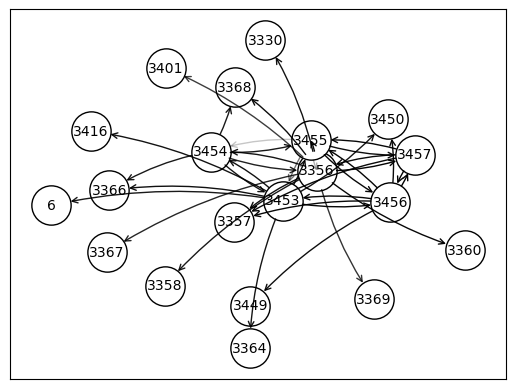

In [36]:
for explanation_type in ['phenomenon']:
    explainer = Explainer(
        model=wrapped_model,
        algorithm=GNNExplainer(epochs=200),
        explanation_type=explanation_type,
        node_mask_type='object',
        edge_mask_type='object',
        model_config=dict(
            mode='regression',
            task_level='node',
            return_type='raw',
        ),
        # threshold_config=dict(threshold_type='hard', value=0.5) 
    )

# 选择一个节点进行解释（例如，节点0）
node_idx = 3455
explanation = explainer(data.x, data.edge_index, index=node_idx, target = data.y,)

# 输出解释结果
print(f'Generated explanations in {explanation.available_explanations}')

# 可视化特征重要性
# path = 'feature_importance.png'
# explanation.visualize_feature_importance(path, top_k=10)
# print(f"Feature importance plot has been saved to '{path}'")

# # 可视化子图
# path = 'subgraph.pdf'
# explanation.visualize_graph(path)
# print(f"Subgraph visualization plot has been saved to '{path}'")

# 获取子图节点索引
edge_mask = explanation.edge_mask > 0  # 使用掩码阈值
edge_index = data.edge_index[:, edge_mask]
node_indices = edge_index.unique().tolist()

explanation.visualize_graph()

In [23]:
# 获取每个节点对应的 node_mask 值
node_mask_values = [explanation.node_mask[idx].item() for idx in node_indices]

# 打印所有索引和对应的 node_mask 值，并保留四位小数
for idx, mask_value in zip(node_indices, node_mask_values):
    print(f"Node: {idx}, value: {mask_value:.4f}")

Node: 5, value: 0.1722
Node: 6, value: 0.2526
Node: 7, value: 0.1743
Node: 8, value: 0.1276
Node: 9, value: 0.4886
Node: 44, value: 0.2323
Node: 3328, value: 0.1710
Node: 3329, value: 0.3424
Node: 3330, value: 0.8561
Node: 3332, value: 0.4134
Node: 3334, value: 0.2921
Node: 3356, value: 0.6337
Node: 3357, value: 0.2808
Node: 3358, value: 0.3993
Node: 3359, value: 0.1737
Node: 3360, value: 0.2169
Node: 3361, value: 0.3343
Node: 3362, value: 0.1627
Node: 3363, value: 0.1748
Node: 3364, value: 0.3750
Node: 3365, value: 0.7543
Node: 3366, value: 0.8409
Node: 3367, value: 0.1273
Node: 3368, value: 0.3097
Node: 3369, value: 0.2846
Node: 3370, value: 0.2660
Node: 3371, value: 0.1443
Node: 3373, value: 0.5403
Node: 3378, value: 0.1478
Node: 3396, value: 0.1605
Node: 3398, value: 0.2018
Node: 3399, value: 0.2602
Node: 3400, value: 0.2165
Node: 3401, value: 0.3366
Node: 3402, value: 0.1568
Node: 3405, value: 0.4021
Node: 3409, value: 0.3409
Node: 3411, value: 0.2459
Node: 3412, value: 0.1923
Nod

In [24]:
# 获取大于0的 edge_mask 值及其对应的边的索引
edge_mask_values = explanation.edge_mask.detach().cpu().numpy()
edge_indices = data.edge_index.detach().cpu().numpy()

# 遍历 edge_mask，找到大于0且包含节点408的值及其索引
for i, mask_value in enumerate(edge_mask_values):
    if mask_value > 0:
        source, target = edge_indices[:, i]
        # if source == 408 or target == 408:
        print(f"Edge ({source}, {target}), value: {mask_value:.4f}")

Edge (5, 6), value: 0.1285
Edge (5, 3416), value: 0.1286
Edge (5, 3450), value: 0.1470
Edge (5, 3453), value: 0.1411
Edge (6, 3450), value: 0.1209
Edge (6, 3453), value: 0.1022
Edge (6, 3416), value: 0.1197
Edge (6, 3456), value: 0.1238
Edge (6, 3364), value: 0.1063
Edge (6, 3366), value: 0.1127
Edge (6, 3449), value: 0.5445
Edge (6, 3454), value: 0.1234
Edge (6, 3455), value: 0.7912
Edge (7, 6), value: 0.1564
Edge (8, 6), value: 0.1180
Edge (9, 6), value: 0.5505
Edge (9, 3416), value: 0.5105
Edge (9, 3450), value: 0.7611
Edge (9, 3453), value: 0.7796
Edge (44, 6), value: 0.3227
Edge (3328, 3330), value: 0.1244
Edge (3328, 3401), value: 0.1237
Edge (3328, 3356), value: 0.1220
Edge (3328, 3360), value: 0.1307
Edge (3328, 3369), value: 0.1265
Edge (3329, 3330), value: 0.3416
Edge (3329, 3401), value: 0.3465
Edge (3330, 3360), value: 0.1545
Edge (3330, 3356), value: 0.1321
Edge (3330, 3401), value: 0.1391
Edge (3330, 3369), value: 0.1794
Edge (3330, 3457), value: 0.1268
Edge (3330, 3357),

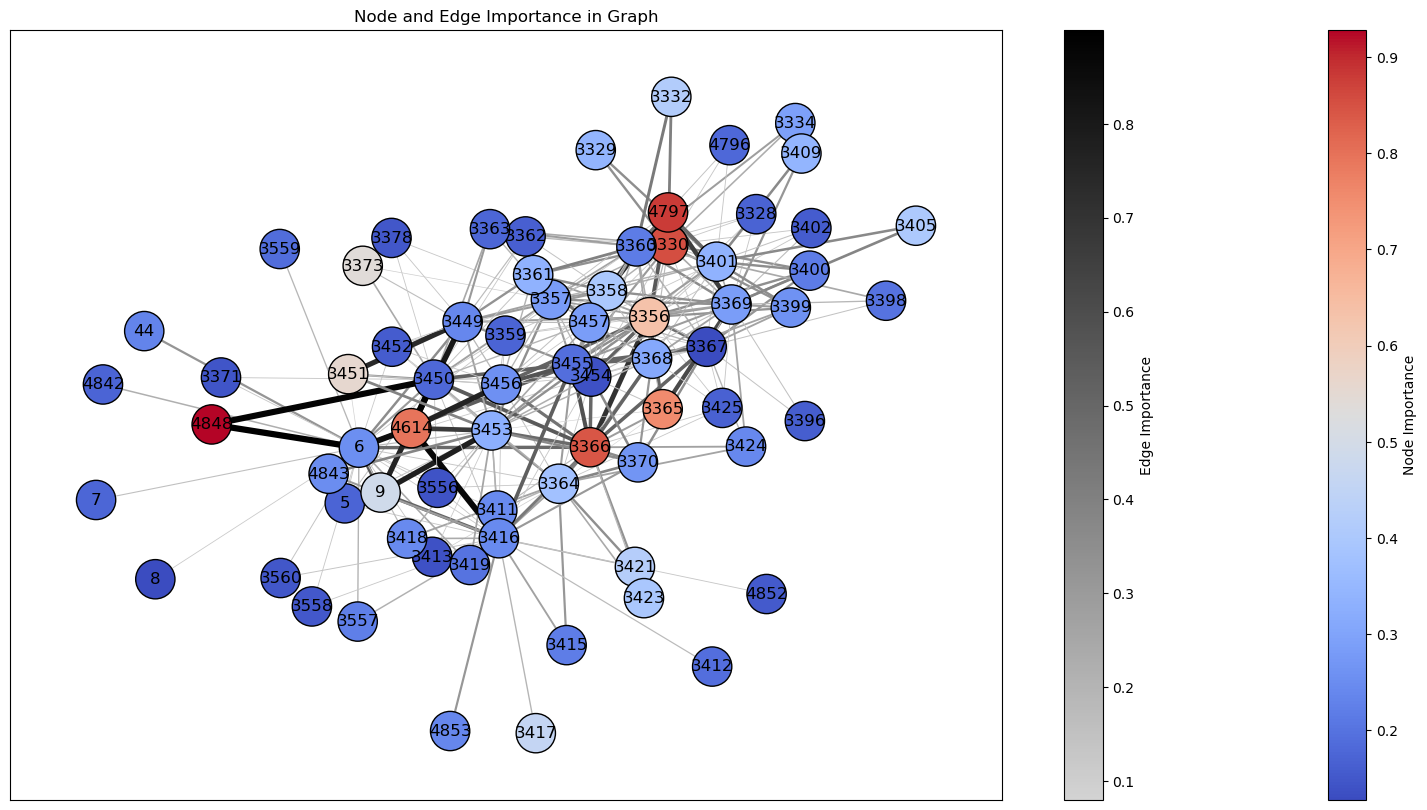

In [25]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# 创建无向图
G = nx.Graph()

# 获取节点的重要性值
node_mask_values = {idx: explanation.node_mask[idx].item() for idx in node_indices}

# 添加节点和节点的重要性值作为属性
for idx, value in node_mask_values.items():
    G.add_node(idx, importance=value)

# 合成无向边并计算边的重要性
edge_importance = {}
for i, mask_value in enumerate(edge_mask_values):
    if mask_value > 0:
        source, target = edge_indices[:, i]
        if source > target:  # 确保无向边的一致性
            source, target = target, source
        if (source, target) in edge_importance:
            edge_importance[(source, target)].append(mask_value)
        else:
            edge_importance[(source, target)] = [mask_value]

# 计算每条无向边的重要性，对于只有一条有向边的情况直接使用该重要性值
edge_importance = {
    edge: np.mean(values) if len(values) > 1 else values[0] for edge, values in edge_importance.items()
}

# 添加边和边的重要性值作为属性
for (source, target), importance in edge_importance.items():
    G.add_edge(source, target, importance=importance)

# 确保所有节点都在图中，即使它们没有连接
isolated_nodes = set(node_mask_values.keys()) - set(G.nodes)
for node in isolated_nodes:
    G.add_node(node, importance=node_mask_values[node])

# 绘制图形
fig, ax = plt.subplots(figsize=(20, 10))  # 调整图的大小
pos = nx.spring_layout(G, k=0.3)  # 调整spring_layout参数以更好地分布节点

# 设置绘图窗口和节点图的背景颜色为淡黄色
# fig.set_facecolor('lightyellow')
# ax.set_facecolor('lightyellow')

# 自定义色图，最低值为灰色，最高值为黑色
cmap = mcolors.LinearSegmentedColormap.from_list('grey_black', ['lightgrey', 'black'])

# 确保所有节点都有 'importance' 属性，提供默认值0
for node in G.nodes:
    if 'importance' not in G.nodes[node]:
        G.nodes[node]['importance'] = 0

# 绘制节点，颜色根据重要性值进行渐变
node_colors = [G.nodes[node]['importance'] for node in G.nodes]
nodes = nx.draw_networkx_nodes(
    G, pos, node_color=node_colors, cmap=plt.cm.coolwarm, node_size=800, edgecolors='black', ax=ax
)
nx.draw_networkx_labels(G, pos, ax=ax)

# 绘制边，颜色和粗细根据重要性值进行调整
edge_widths = [G[u][v]['importance'] * 5 for u, v in G.edges]  # 调整乘数以获得适合的宽度
edge_colors = [G[u][v]['importance'] for u, v in G.edges]
edges = nx.draw_networkx_edges(
    G, pos, width=edge_widths, edge_color=edge_colors, edge_cmap=cmap, ax=ax
)

# 添加颜色条以显示重要性
sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
sm._A = []
plt.colorbar(sm, ax=ax, label='Node Importance')

sm_edges = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(edge_colors), vmax=max(edge_colors)))
sm_edges._A = []
plt.colorbar(sm_edges, ax=ax, label='Edge Importance')

plt.title("Node and Edge Importance in Graph")
plt.show()


Node indices: [   6 3330 3356 3357 3358 3360 3364 3366 3367 3368 3369 3401 3416 3449
 3450 3453 3454 3455 3456 3457]
Edge indices: [   36 19770 19926 19928 19931 19933 19938 19939 19940 19954 19974 19986
 19987 19990 19996 20000 20002 20199 20295 20484 20491 20492 20507 20508
 20509 20510 20513 20514 20515 20516 20517 20518 20519 20523 20524 20525
 20526 20528 20529]
Node positions: {6: (543631.4493965654, 184385.2518637335), 3330: (541865.8602534509, 183707.02637275247), 3356: (542264.0216580781, 184080.49691803806), 3357: (542542.153034213, 183814.16829912883), 3358: (542179.6139092873, 183835.86937817014), 3360: (542042.4046183934, 183582.56188435626), 3364: (542939.9328797493, 184910.4946108677), 3366: (542767.8461111177, 184716.5253453401), 3367: (542071.948306461, 184407.99893054357), 3368: (542511.7698517095, 184487.42806677107), 3369: (541781.4639524732, 184246.75184527415), 3401: (541589.927801801, 184072.9923582584), 3416: (543336.1992768531, 185170.80656443178), 3449: (54304

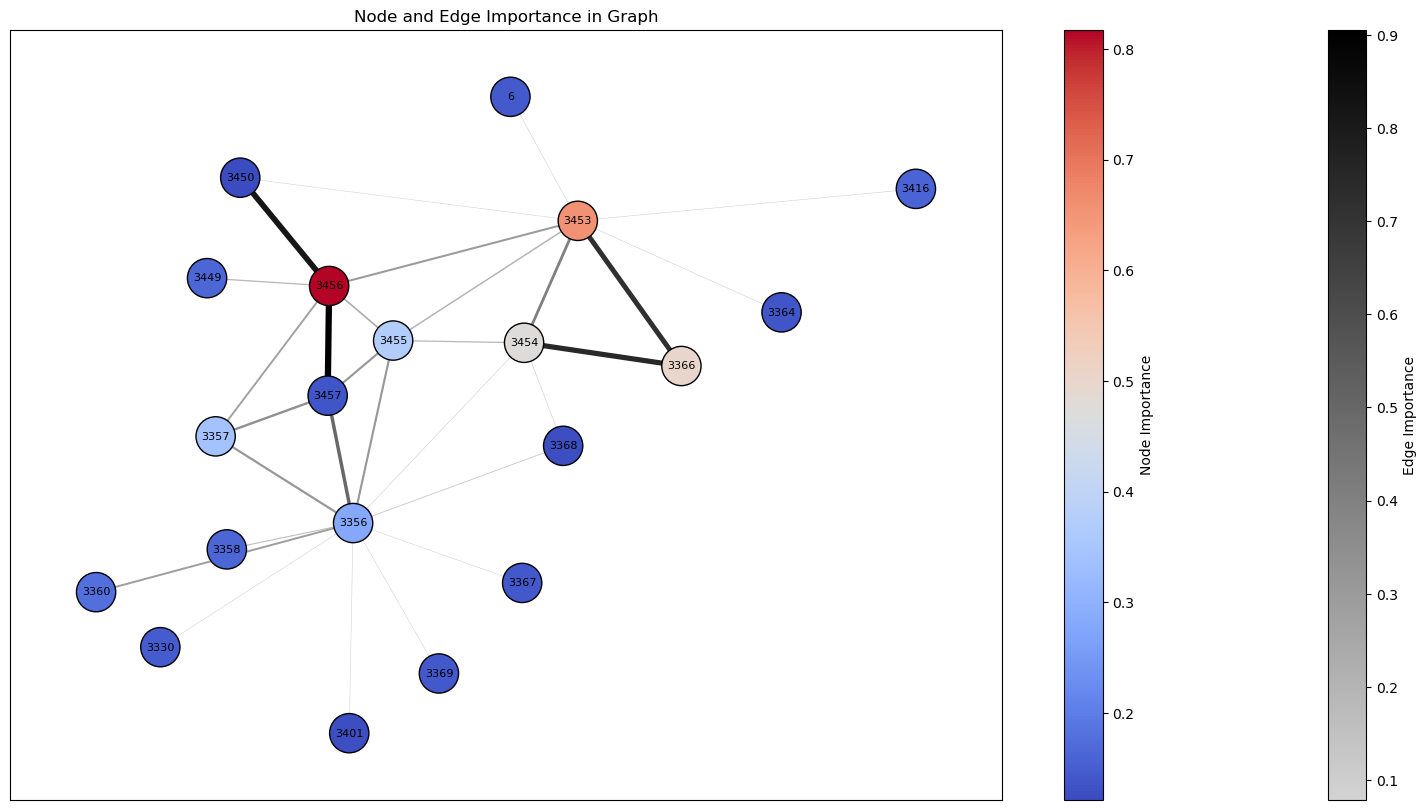

In [17]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# 获取解释子图中的节点
node_indices = np.where(explanation.node_mask > 0)[0]
edge_indices = np.where(explanation.edge_mask > 0)[0]

# 获取节点的位置数据
node_positions = data.pos.numpy()

# 创建无向图
G = nx.Graph()

# 获取节点的重要性值
node_mask_values = {idx: explanation.node_mask[idx].item() for idx in node_indices}

# 添加解释子图中的节点和节点的重要性值作为属性
for idx in node_indices:
    value = explanation.node_mask[idx].item()
    lat, lon = node_positions[idx]
    G.add_node(int(idx), importance=value, pos=(lon, lat))

# 合成无向边并计算边的重要性
edge_importance = {}
for i in edge_indices:
    mask_value = explanation.edge_mask[i].item()
    source, target = data.edge_index[:, i]
    if source.item() in node_indices and target.item() in node_indices:  # 仅添加解释子图中的边
        if source.item() > target.item():  # 确保无向边的一致性
            source, target = target, source
        if (source.item(), target.item()) in edge_importance:
            edge_importance[(source.item(), target.item())].append(mask_value)
        else:
            edge_importance[(source.item(), target.item())] = [mask_value]

# 输出调试信息
print("Node indices:", node_indices)
print("Edge indices:", edge_indices)
print("Node positions:", {idx: (node_positions[idx][0], node_positions[idx][1]) for idx in node_indices})
print("Edge importance:", edge_importance)

# 计算每条无向边的重要性，对于只有一条有向边的情况直接使用该重要性值
edge_importance = {
    edge: np.mean(values) if len(values) > 1 else values[0] for edge, values in edge_importance.items()
}

# 添加边和边的重要性值作为属性
for (source, target), importance in edge_importance.items():
    G.add_edge(source, target, importance=importance)

# 获取节点位置
pos = nx.get_node_attributes(G, 'pos')

# 绘制图形
fig, ax = plt.subplots(figsize=(20, 10))  # 调整图的大小

# 设置绘图窗口和节点图的背景颜色为淡黄色
# fig.set_facecolor('lightyellow')
# ax.set_facecolor('lightyellow')

# 自定义色图，最低值为灰色，最高值为黑色
cmap = mcolors.LinearSegmentedColormap.from_list('grey_black', ['lightgrey', 'black'])

# 绘制节点，颜色根据重要性值进行渐变
node_colors = [G.nodes[node]['importance'] for node in G.nodes]
nodes = nx.draw_networkx_nodes(
    G, pos, node_color=node_colors, cmap=plt.cm.coolwarm, node_size=800, edgecolors='black', ax=ax
)
nx.draw_networkx_labels(G, pos, ax=ax, font_size=8)

# 确保有边被添加到图中
if len(G.edges) > 0:
    # 绘制边，颜色和粗细根据重要性值进行调整
    edge_widths = [G[u][v]['importance'] * 5 for u, v in G.edges]  # 调整乘数以获得适合的宽度
    edge_colors = [G[u][v]['importance'] for u, v in G.edges]
    edges = nx.draw_networkx_edges(
        G, pos, width=edge_widths, edge_color=edge_colors, edge_cmap=cmap, ax=ax
    )

    # 添加颜色条以显示重要性
    sm_edges = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(edge_colors), vmax=max(edge_colors)))
    sm_edges._A = []
    plt.colorbar(sm_edges, ax=ax, label='Edge Importance')

# 添加节点的重要性颜色条
sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
sm._A = []
plt.colorbar(sm, ax=ax, label='Node Importance')

plt.title("Node and Edge Importance in Graph")
plt.show()


Node indices: [   5    6    7    8    9   44 3328 3329 3330 3332 3334 3356 3357 3358
 3359 3360 3361 3362 3363 3364 3365 3366 3367 3368 3369 3370 3371 3373
 3378 3396 3398 3399 3400 3401 3402 3405 3409 3411 3412 3413 3415 3416
 3417 3418 3419 3421 3423 3424 3425 3449 3450 3451 3452 3453 3454 3455
 3456 3457 3556 3557 3558 3559 3560 4614 4796 4797 4842 4843 4848 4852
 4853]
Edge indices: [   85    95   101   102   105   109   110   111   115   116   129   132
   133   140   157   170   182   188   189   876 65491 65493 65497 65498
 65502 65511 65514 65524 65525 65526 65527 65529 65532 65533 65537 65538
 65543 65544 65573 65575 65612 65615 66062 66063 66064 66065 66066 66067
 66068 66069 66070 66071 66072 66074 66078 66084 66085 66086 66089 66090
 66091 66092 66093 66094 66097 66098 66099 66103 66104 66106 66107 66108
 66109 66110 66112 66113 66115 66116 66117 66118 66119 66120 66121 66122
 66123 66126 66133 66134 66135 66137 66138 66139 66140 66142 66149 66150
 66151 66152 66158 66160 6

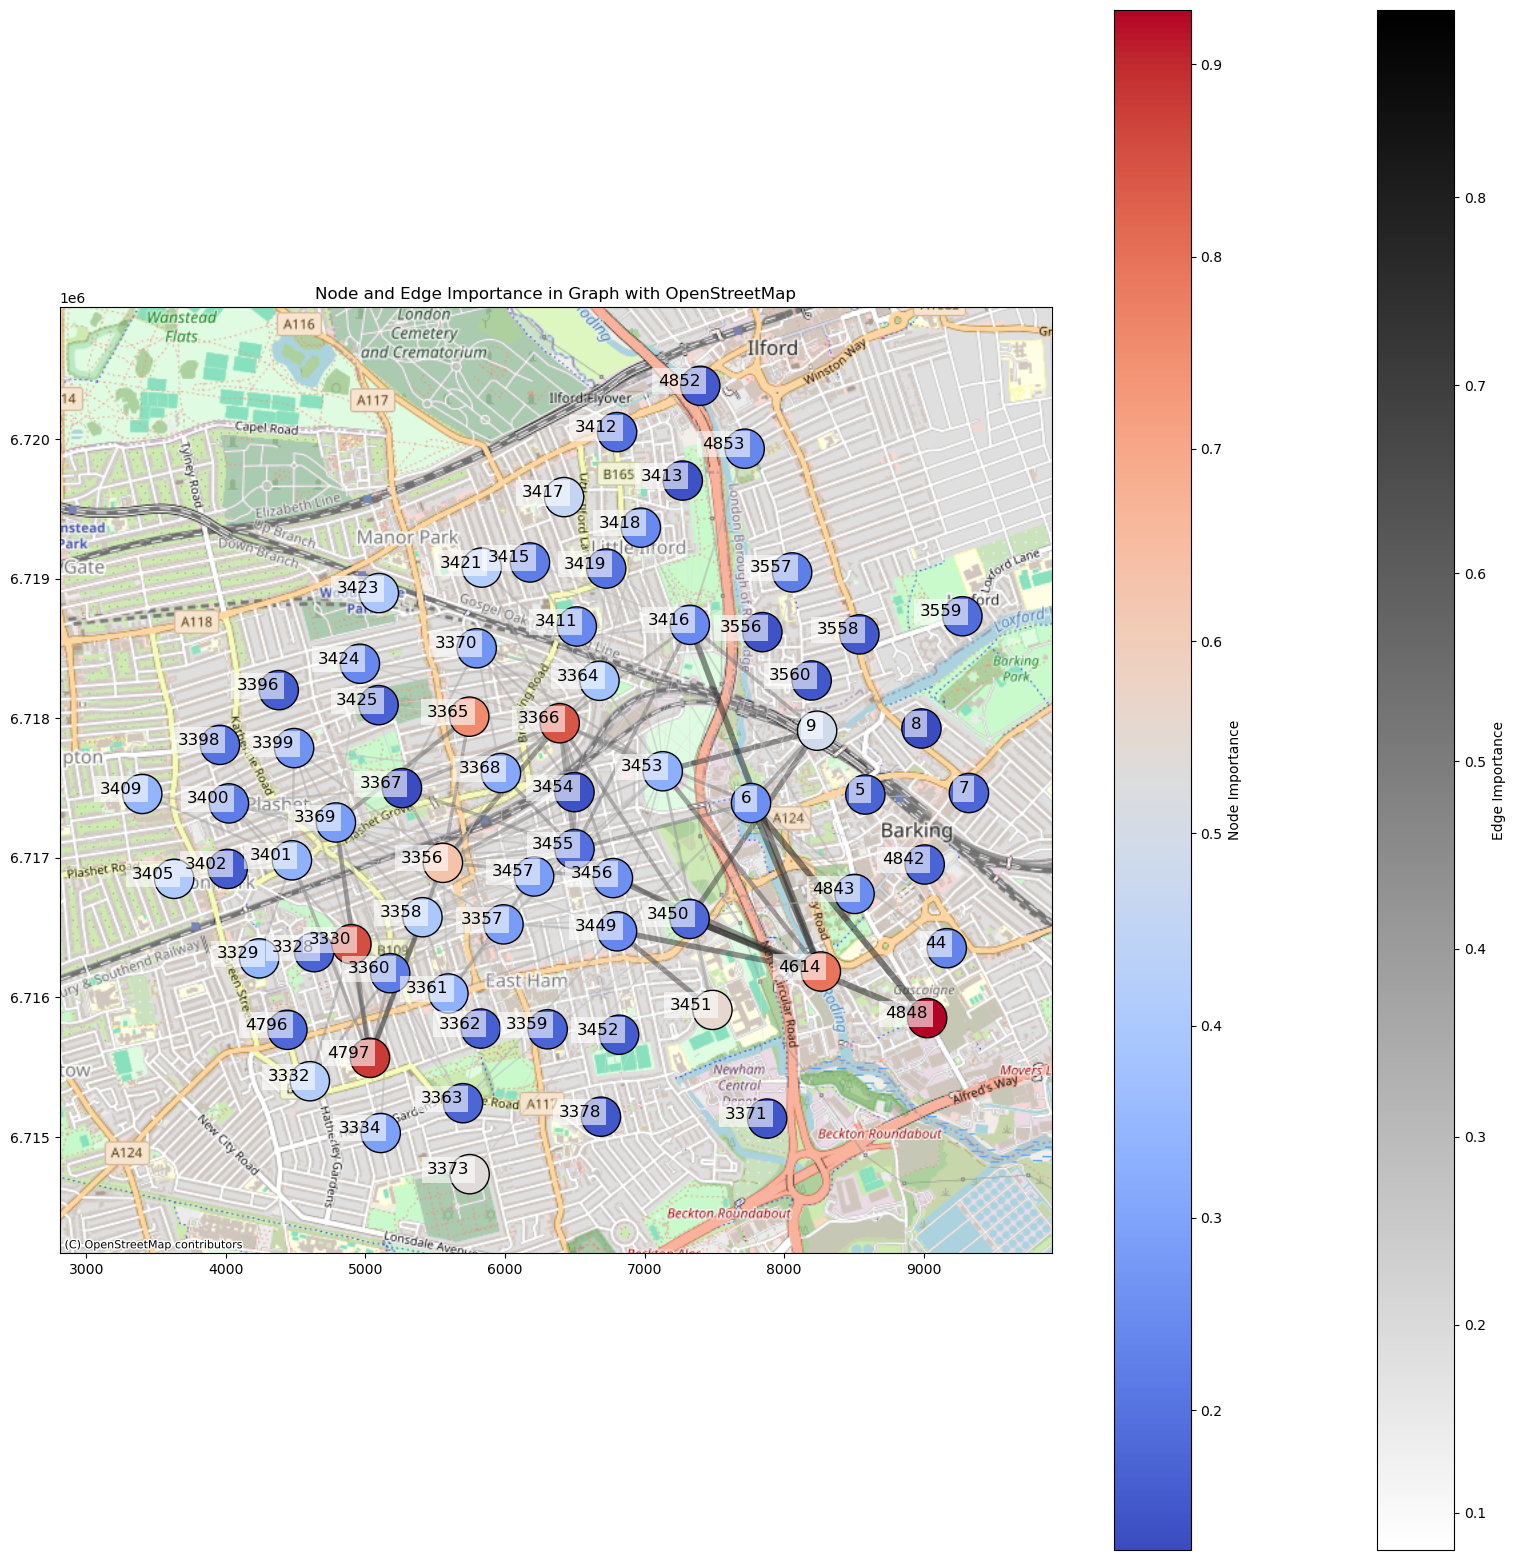

In [27]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx

# 获取解释子图中的节点
node_indices = np.where(explanation.node_mask > 0)[0]
edge_indices = np.where(explanation.edge_mask > 0)[0]

# 获取节点的位置数据
node_positions = data.pos.numpy()

# 创建无向图
G = nx.Graph()

# 获取节点的重要性值
node_mask_values = {idx: explanation.node_mask[idx].item() for idx in node_indices}

# 添加解释子图中的节点和节点的重要性值作为属性
for idx in node_indices:
    value = explanation.node_mask[idx].item()
    lat, lon = node_positions[idx]
    G.add_node(int(idx), importance=value, pos=(lon, lat))

# 合成无向边并计算边的重要性
edge_importance = {}
for i in edge_indices:
    mask_value = explanation.edge_mask[i].item()
    source, target = data.edge_index[:, i]
    if source.item() in node_indices and target.item() in node_indices:  # 仅添加解释子图中的边
        if source.item() > target.item():  # 确保无向边的一致性
            source, target = target, source
        if (source.item(), target.item()) in edge_importance:
            edge_importance[(source.item(), target.item())].append(mask_value)
        else:
            edge_importance[(source.item(), target.item())] = [mask_value]

# 输出调试信息
print("Node indices:", node_indices)
print("Edge indices:", edge_indices)
print("Node positions:", {idx: (node_positions[idx][0], node_positions[idx][1]) for idx in node_indices})
print("Edge importance:", edge_importance)

# 计算每条无向边的重要性，对于只有一条有向边的情况直接使用该重要性值
edge_importance = {
    edge: np.mean(values) if len(values) > 1 else values[0] for edge, values in edge_importance.items()
}

# 添加边和边的重要性值作为属性
for (source, target), importance in edge_importance.items():
    G.add_edge(source, target, importance=importance)

# 获取节点位置
pos = nx.get_node_attributes(G, 'pos')

# 将节点位置转换为GeoDataFrame
geometry = [Point(lon, lat) for lat, lon in pos.values()]
node_importance = [G.nodes[node]['importance'] for node in G.nodes]
gdf = gpd.GeoDataFrame(list(pos.keys()), geometry=geometry, columns=['node'])
gdf['importance'] = node_importance

# 设置原始坐标系为EPSG:27700（英国国家格网）
gdf.set_crs(epsg=27700, inplace=True)
# 转换为WGS84坐标系（EPSG:4326）
gdf = gdf.to_crs(epsg=4326)

# 转换为墨卡托投影以匹配OpenStreetMap
gdf = gdf.to_crs(epsg=3857)

# 调试信息：检查转换后的坐标和边界框值
print("Converted coordinates:\n", gdf)
bounds = gdf.total_bounds  # 获取GeoDataFrame的边界框 [minx, miny, maxx, maxy]
print("Bounds:", bounds)

# 绘制图形
fig, ax = plt.subplots(figsize=(20, 20))

# 设置地图范围
if np.isfinite(bounds).all():
    x_buffer = (bounds[2] - bounds[0]) * 0.1
    y_buffer = (bounds[3] - bounds[1]) * 0.1
    ax.set_xlim([bounds[0] - x_buffer, bounds[2] + x_buffer])
    ax.set_ylim([bounds[1] - y_buffer, bounds[3] + y_buffer])
else:
    print("Invalid bounds detected, skipping axis limits setting")

# 添加OpenStreetMap底图
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# 绘制GeoDataFrame并使用importance列作为颜色
gdf.plot(ax=ax, column='importance', cmap=plt.cm.coolwarm, markersize=800, edgecolor='black', zorder=5)

# 确保有边被添加到图中
if len(G.edges) > 0:
    # 绘制边，颜色和粗细根据重要性值进行调整
    for (source, target), importance in edge_importance.items():
        source_pos = gdf.loc[gdf['node'] == source, 'geometry'].values[0]
        target_pos = gdf.loc[gdf['node'] == target, 'geometry'].values[0]
        ax.plot([source_pos.x, target_pos.x], [source_pos.y, target_pos.y], 
                color=plt.cm.binary(importance), linewidth=5*importance, alpha=0.5, zorder=1)

    # 添加颜色条以显示边的重要性
    sm_edges = plt.cm.ScalarMappable(cmap=plt.cm.binary, norm=plt.Normalize(vmin=min(edge_importance.values()), vmax=max(edge_importance.values())))
    sm_edges._A = []
    plt.colorbar(sm_edges, ax=ax, label='Edge Importance')

# 添加节点的重要性颜色条
sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=min(node_importance), vmax=max(node_importance)))
sm._A = []
plt.colorbar(sm, ax=ax, label='Node Importance')

# 添加节点标签
for node, (lat, lon) in pos.items():
    point = gpd.GeoSeries([Point(lon, lat)], crs="EPSG:27700").to_crs("EPSG:3857").geometry[0]
    ax.text(point.x, point.y, str(node), fontsize=12, ha='right', zorder=10, bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

plt.title("Node and Edge Importance in Graph with OpenStreetMap")
plt.show()


Node indices: [   6 3330 3356 3357 3358 3360 3364 3366 3367 3368 3369 3401 3416 3449
 3450 3453 3454 3455 3456 3457]
Edge indices: [   36 19770 19926 19928 19931 19933 19938 19939 19940 19954 19974 19986
 19987 19990 19996 20000 20002 20199 20295 20484 20491 20492 20507 20508
 20509 20510 20513 20514 20515 20516 20517 20518 20519 20523 20524 20525
 20526 20528 20529]
Node positions: {6: (543631.4493965654, 184385.2518637335), 3330: (541865.8602534509, 183707.02637275247), 3356: (542264.0216580781, 184080.49691803806), 3357: (542542.153034213, 183814.16829912883), 3358: (542179.6139092873, 183835.86937817014), 3360: (542042.4046183934, 183582.56188435626), 3364: (542939.9328797493, 184910.4946108677), 3366: (542767.8461111177, 184716.5253453401), 3367: (542071.948306461, 184407.99893054357), 3368: (542511.7698517095, 184487.42806677107), 3369: (541781.4639524732, 184246.75184527415), 3401: (541589.927801801, 184072.9923582584), 3416: (543336.1992768531, 185170.80656443178), 3449: (54304

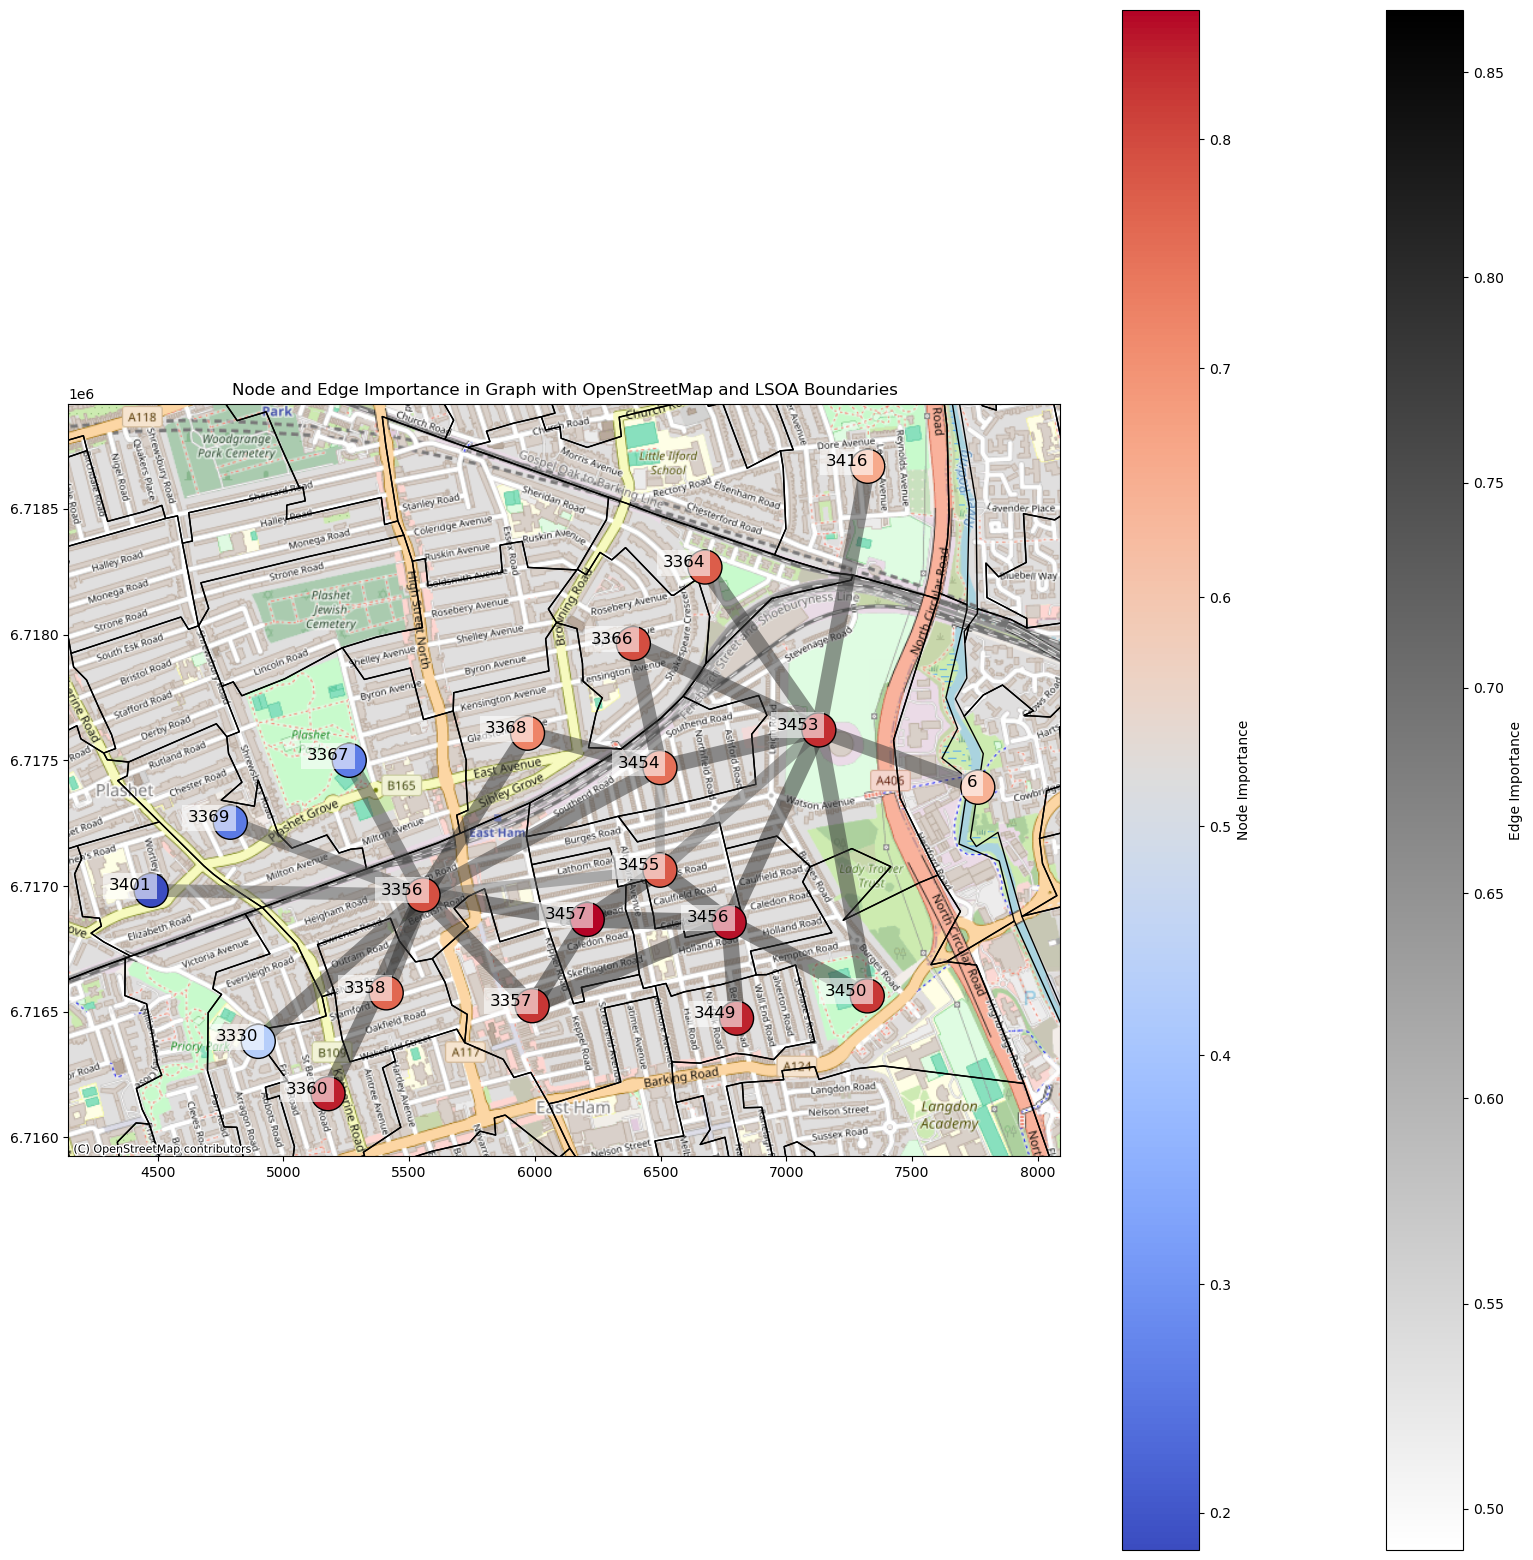

In [37]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx

# 读取LSOA的shapefile并转换坐标系
fp = 'LSOA_(Dec_2021)_Boundaries_Generalised_Clipped_EW_(BGC).shp'
London_lsoas_2021 = gpd.read_file(fp).rename(columns={'LSOA21CD':'geography code'})
London_lsoas_2021 = London_lsoas_2021[London_lsoas_2021["geography code"].str.startswith("E")]

# 设置原始坐标系为EPSG:27700（英国国家格网）
London_lsoas_2021.set_crs(epsg=27700, inplace=True)
# 转换为WGS84坐标系（EPSG:4326）
London_lsoas_2021 = London_lsoas_2021.to_crs(epsg=4326)
# 转换为墨卡托投影以匹配OpenStreetMap
London_lsoas_2021 = London_lsoas_2021.to_crs(epsg=3857)

# 获取解释子图中的节点
node_indices = np.where(explanation.node_mask > 0)[0]
edge_indices = np.where(explanation.edge_mask > 0)[0]

# 获取节点的位置数据
node_positions = data.pos.numpy()

# 创建无向图
G = nx.Graph()

# 获取节点的重要性值
node_mask_values = {idx: explanation.node_mask[idx].item() for idx in node_indices}

# 添加解释子图中的节点和节点的重要性值作为属性
for idx in node_indices:
    value = explanation.node_mask[idx].item()
    lat, lon = node_positions[idx]
    G.add_node(int(idx), importance=value, pos=(lon, lat))

# 合成无向边并计算边的重要性
edge_importance = {}
for i in edge_indices:
    mask_value = explanation.edge_mask[i].item()
    source, target = data.edge_index[:, i]
    if source.item() in node_indices and target.item() in node_indices:  # 仅添加解释子图中的边
        if source.item() > target.item():  # 确保无向边的一致性
            source, target = target, source
        if (source.item(), target.item()) in edge_importance:
            edge_importance[(source.item(), target.item())].append(mask_value)
        else:
            edge_importance[(source.item(), target.item())] = [mask_value]

# 输出调试信息
print("Node indices:", node_indices)
print("Edge indices:", edge_indices)
print("Node positions:", {idx: (node_positions[idx][0], node_positions[idx][1]) for idx in node_indices})
print("Edge importance:", edge_importance)

# 计算每条无向边的重要性，对于只有一条有向边的情况直接使用该重要性值
edge_importance = {
    edge: np.mean(values) if len(values) > 1 else values[0] for edge, values in edge_importance.items()
}

# 添加边和边的重要性值作为属性
for (source, target), importance in edge_importance.items():
    G.add_edge(source, target, importance=importance)

# 获取节点位置
pos = nx.get_node_attributes(G, 'pos')

# 将节点位置转换为GeoDataFrame
geometry = [Point(lon, lat) for lat, lon in pos.values()]
node_importance = [G.nodes[node]['importance'] for node in G.nodes]
gdf = gpd.GeoDataFrame(list(pos.keys()), geometry=geometry, columns=['node'])
gdf['importance'] = node_importance

# 设置原始坐标系为EPSG:27700（英国国家格网）
gdf.set_crs(epsg=27700, inplace=True)
# 转换为WGS84坐标系（EPSG:4326）
gdf = gdf.to_crs(epsg=4326)
# 转换为墨卡托投影以匹配OpenStreetMap
gdf = gdf.to_crs(epsg=3857)

# 调试信息：检查转换后的坐标和边界框值
print("Converted coordinates:\n", gdf)
bounds = gdf.total_bounds  # 获取GeoDataFrame的边界框 [minx, miny, maxx, maxy]
print("Bounds:", bounds)

# 绘制图形
fig, ax = plt.subplots(figsize=(20, 20))

# 设置地图范围
if np.isfinite(bounds).all():
    x_buffer = (bounds[2] - bounds[0]) * 0.1
    y_buffer = (bounds[3] - bounds[1]) * 0.1
    ax.set_xlim([bounds[0] - x_buffer, bounds[2] + x_buffer])
    ax.set_ylim([bounds[1] - y_buffer, bounds[3] + y_buffer])
else:
    print("Invalid bounds detected, skipping axis limits setting")

# 添加OpenStreetMap底图
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# 绘制LSOA边界
London_lsoas_2021.boundary.plot(ax=ax, linewidth=1, edgecolor='black', zorder=2)

# 绘制GeoDataFrame并使用importance列作为颜色
gdf.plot(ax=ax, column='importance', cmap=plt.cm.coolwarm, markersize=600, edgecolor='black', zorder=5)

# 确保有边被添加到图中
if len(G.edges) > 0:
    # 绘制边，颜色和粗细根据重要性值进行调整
    for (source, target), importance in edge_importance.items():
        source_pos = gdf.loc[gdf['node'] == source, 'geometry'].values[0]
        target_pos = gdf.loc[gdf['node'] == target, 'geometry'].values[0]
        ax.plot([source_pos.x, target_pos.x], [source_pos.y, target_pos.y], 
                color=plt.cm.binary(importance), linewidth=14*importance, alpha=0.5, zorder=3)

    # 添加颜色条以显示边的重要性
    sm_edges = plt.cm.ScalarMappable(cmap=plt.cm.binary, norm=plt.Normalize(vmin=min(edge_importance.values()), vmax=max(edge_importance.values())))
    sm_edges._A = []
    plt.colorbar(sm_edges, ax=ax, label='Edge Importance')

# 添加节点的重要性颜色条
sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=min(node_importance), vmax=max(node_importance)))
sm._A = []
plt.colorbar(sm, ax=ax, label='Node Importance')

# 添加节点标签
for node, (lat, lon) in pos.items():
    point = gpd.GeoSeries([Point(lon, lat)], crs="EPSG:27700").to_crs("EPSG:3857").geometry[0]
    ax.text(point.x, point.y, str(node), fontsize=12, ha='right', zorder=10, bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

plt.title("Node and Edge Importance in Graph with OpenStreetMap and LSOA Boundaries")
plt.show()